In [ ]:
!pip uninstall scikit-learn --yes
!pip uninstall imblearn --yes
!pip install scikit-learn==1.2.2
!pip install imblearn
!pip install xgboost

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2


ERROR: Exception:
Traceback (most recent call last):
  File "D:\Android\AnacondaPython\lib\site-packages\pip\_internal\cli\base_command.py", line 180, in exc_logging_wrapper
    status = run_func(*args)
  File "D:\Android\AnacondaPython\lib\site-packages\pip\_internal\commands\uninstall.py", line 110, in run
    uninstall_pathset.commit()
  File "D:\Android\AnacondaPython\lib\site-packages\pip\_internal\req\req_uninstall.py", line 432, in commit
    self._moved_paths.commit()
  File "D:\Android\AnacondaPython\lib\site-packages\pip\_internal\req\req_uninstall.py", line 278, in commit
    save_dir.cleanup()
  File "D:\Android\AnacondaPython\lib\site-packages\pip\_internal\utils\temp_dir.py", line 173, in cleanup
    rmtree(self._path)
  File "D:\Android\AnacondaPython\lib\site-packages\pip\_vendor\tenacity\__init__.py", line 291, in wrapped_f
    return self(f, *args, **kw)
  File "D:\Android\AnacondaPython\lib\site-packages\pip\_vendor\tenacity\__init__.py", line 381, in __call__
    do

Found existing installation: imblearn 0.0
Uninstalling imblearn-0.0:
  Successfully uninstalled imblearn-0.0
  Obtaining dependency information for scikit-learn==1.2.2 from https://files.pythonhosted.org/packages/5b/fb/478a0460ae2843dd2fc7a7f9ddcd8bb033ae21eb968df6a8cbe8094a28bc/scikit_learn-1.2.2-cp38-cp38-win_amd64.whl.metadata
  Using cached scikit_learn-1.2.2-cp38-cp38-win_amd64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp38-cp38-win_amd64.whl (8.3 MB)
  Obtaining dependency information for imblearn from https://files.pythonhosted.org/packages/81/a7/4179e6ebfd654bd0eac0b9c06125b8b4c96a9d0a8ff9e9507eb2a26d2d7e/imblearn-0.0-py2.py3-none-any.whl.metadata
  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/a2/48/d5da8591891327b0faf08179d420fba3893c6134bdd449497c5329e4cb01/xgboost-2.1.0-py3-none-win_amd64.whl.met

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pickle
from collections import Counter
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
import xgboost as xgb
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import pickle


In [ ]:
data = pd.read_csv("Msg.csv")
data.head()

,Message,Type
0,Rs.400.00 credited to a/c *1234 on 06/06/2024 ...,Transaction
1,A/c *4354 debited Rs. 10000.00 on 13-06-24 to ...,Transaction
2,Rs.12100.00 credited to a/c *8984 on 29/05/202...,Transaction
3,Rs.100.00 credited to a/c *4244 on 08/05/2024 ...,Transaction
4,Qwerty has requested money from you on PhonePe...,Transaction


In [ ]:
data.columns

Index(['Message', 'Type'], dtype='object')

In [ ]:
mod_data = pd.get_dummies(data, columns = ['Type'], dtype=int)
mod_data

,Message,Type_Bank Promo,Type_Transaction
0,Rs.400.00 credited to a/c *1234 on 06/06/2024 ...,0,1
1,A/c *4354 debited Rs. 10000.00 on 13-06-24 to ...,0,1
2,Rs.12100.00 credited to a/c *8984 on 29/05/202...,0,1
3,Rs.100.00 credited to a/c *4244 on 08/05/2024 ...,0,1
4,Qwerty has requested money from you on PhonePe...,0,1
...,...,...,...
62,Short on funds? Get Rs475000 Loan on your HDFC...,1,0
63,Avail instant disbursement with HDFC Bank Rs. ...,1,0
64,Hi In need of instant cash? Rs.600000 @0.99% ...,1,0
65,Dear Easy steps to cash: HDFC Bank Personal Lo...,1,0


In [ ]:

print("Total Bank Promo messages : ", mod_data["Type_Bank Promo"].value_counts())
print("***********************")
print("Total Transaction Bank messages : ", mod_data["Type_Transaction"].value_counts())
print("**********************")

Total Bank Promo messages :  Type_Bank Promo
0    47
1    20
Name: count, dtype: int64
***********************
Total Transaction Bank messages :  Type_Transaction
1    45
0    22
Name: count, dtype: int64
**********************


In [ ]:
X = mod_data['Message']
y = mod_data[mod_data.columns[1:]].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=2022)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [ ]:
MAX_FEATURES = 200000
# number of words in the vocab
# drop this number if Ram usage is more

In [ ]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [ ]:
vectorizer.adapt(X_train)  # Fit the vectorizer on the training data

In [ ]:
X_train_vectorized = vectorizer(X_train).numpy()
X_test_vectorized = vectorizer(X_test).numpy()

In [ ]:
# Convert one-hot encoded labels to integer labels
y_train_int = np.argmax(y_train, axis=1)
y_test_int = np.argmax(y_test, axis=1)

In [ ]:
# Check the size of the dataset before applying SMOTE
print(f"Original training set size: X_train_vectorized.shape[0] = {X_train_vectorized.shape[0]}")
print(f"Original training labels size: y_train.shape[0] = {y_train.shape[0]}")
print(f"Class distribution before SMOTE: {Counter(y_test_int)}")

Original training set size: X_train_vectorized.shape[0] = 46
Original training labels size: y_train.shape[0] = 46
Class distribution before SMOTE: Counter({1: 14, 0: 7})


In [ ]:
# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=2022)
X_train_smote, y_train_smote = smote.fit_resample(X_train_vectorized, y_train_int)

In [ ]:
# Check the size of the dataset after applying SMOTE
print(f"SMOTE training set size: X_train_smote.shape[0] = {X_train_smote.shape[0]}")
print(f"SMOTE training labels size: y_train_smote.shape[0] = {y_train_smote.shape[0]}")
print(f"Class distribution after SMOTE: {Counter(y_train_smote)}")

SMOTE training set size: X_train_smote.shape[0] = 62
SMOTE training labels size: y_train_smote.shape[0] = 62
Class distribution after SMOTE: Counter({1: 31, 0: 31})


In [ ]:
logistic_classifier = LogisticRegression()
logistic_classifier.fit(X_train_smote, y_train_smote)
y_pred = logistic_classifier.predict(X_test_vectorized)
print(confusion_matrix(y_test_int,y_pred))
print(classification_report(y_test_int,y_pred))

[[ 3  4]
 [ 2 12]]
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.75      0.86      0.80        14

    accuracy                           0.71        21
   macro avg       0.68      0.64      0.65        21
weighted avg       0.70      0.71      0.70        21



D:\Android\AnacondaPython\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
svc_classifier = SVC(probability=True, kernel='linear')
svc_classifier.fit(X_train_smote, y_train_smote)

# Make Prediction & print the result
y_pred = svc_classifier.predict(X_test_vectorized)

print(classification_report(y_test_int,y_pred))


              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.75      0.86      0.80        14

    accuracy                           0.71        21
   macro avg       0.68      0.64      0.65        21
weighted avg       0.70      0.71      0.70        21



In [ ]:
# Define the XGBoost model
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=2022
)

# Train the model
xgb_model.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred = xgb_model.predict(X_test_vectorized)

# Evaluate the model
print(confusion_matrix(y_test_int, y_pred))
print(classification_report(y_test_int, y_pred))

[[ 6  1]
 [ 1 13]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.93      0.93      0.93        14

    accuracy                           0.90        21
   macro avg       0.89      0.89      0.89        21
weighted avg       0.90      0.90      0.90        21



D:\Android\AnacondaPython\lib\site-packages\xgboost\core.py:158: UserWarning: [22:45:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=2022)
X_train_smote, y_train_smote = smote.fit_resample(X_train_vectorized, y_train_int)

In [ ]:
# Check class distribution after SMOTE
print(f"Class distribution after SMOTE: {Counter(y_train_smote)}")

Class distribution after SMOTE: Counter({1: 31, 0: 31})


In [ ]:
# Check the size of the dataset after applying SMOTE
print(f"SMOTE training set size: X_train_smote.shape[0] = {X_train_smote.shape[0]}")
print(f"SMOTE training labels size: y_train_smote.shape[0] = {y_train_smote.shape[0]}")
print(f"Class distribution after SMOTE: {Counter(y_train_smote)}")

SMOTE training set size: X_train_smote.shape[0] = 62
SMOTE training labels size: y_train_smote.shape[0] = 62
Class distribution after SMOTE: Counter({1: 31, 0: 31})


In [ ]:
# Create TensorFlow datasets
def create_tf_dataset(X, y, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
# Convert y_train_smote back to one-hot encoding if needed
y_train_smote = to_categorical(y_train_smote, num_classes=2)
y_test = to_categorical(np.argmax(y_test, axis=1), num_classes=2)

In [ ]:
train_dataset = create_tf_dataset(X_train_smote, y_train_smote)
test_dataset = create_tf_dataset(X_test_vectorized, y_test)

In [ ]:
train_size = max(int(len(train_dataset) * 0.7), 1)
val_size = max(int(len(train_dataset) * 0.2), 1)

train = train_dataset.take(train_size)
val = train_dataset.skip(train_size).take(val_size)

In [ ]:
print("Dataset Size: ", (len(train_dataset)))
print("Train Size: ", train_size)
print("Validation Size: ", val_size)
print("Test Size: ", len(test_dataset))

Dataset Size:  4
Train Size:  2
Validation Size:  1
Test Size:  2


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
sequential_model = Sequential()
# Create the embedding layer
sequential_model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
sequential_model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
sequential_model.add(Dense(128, activation='relu'))
sequential_model.add(Dense(256, activation='relu'))
sequential_model.add(Dense(128, activation='relu'))
# Final layer
sequential_model.add(Dense(2, activation='sigmoid'))

In [ ]:
sequential_model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics = ['accuracy'])

In [ ]:
sequential_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_5 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 128)               8320      
                                                                 
 dense_21 (Dense)            (None, 256)               33024     
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dense_23 (Dense)            (None, 2)                 258       
                                                      

In [ ]:
pickle.dump(model, open('model.pkl', 'wb'))

In [ ]:
# Define the EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

history = sequential_model.fit(train, epochs=12, validation_data=val, shuffle=True, callbacks=[early_stopping])

Epoch 1/12
2/2 [==============================] - 17s 5s/step - loss: 0.6931 - accuracy: 0.4062 - val_loss: 0.6940 - val_accuracy: 0.3750
Epoch 2/12
2/2 [==============================] - 5s 2s/step - loss: 0.6923 - accuracy: 0.4688 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 3/12
2/2 [==============================] - 4s 2s/step - loss: 0.6890 - accuracy: 0.5625 - val_loss: 0.6964 - val_accuracy: 0.3125
Epoch 4/12
2/2 [==============================] - 4s 2s/step - loss: 0.6883 - accuracy: 0.5000 - val_loss: 0.6823 - val_accuracy: 0.5625
Epoch 5/12
2/2 [==============================] - 4s 2s/step - loss: 0.6843 - accuracy: 0.5625 - val_loss: 0.6798 - val_accuracy: 0.8125
Epoch 6/12
2/2 [==============================] - 4s 2s/step - loss: 0.6750 - accuracy: 0.8750 - val_loss: 0.6750 - val_accuracy: 0.8125
Epoch 7/12
2/2 [==============================] - 4s 2s/step - loss: 0.6637 - accuracy: 0.8750 - val_loss: 0.6488 - val_accuracy: 0.8750
Epoch 8/12
2/2 [========================

In [ ]:
# Evaluate the model
loss, accuracy = sequential_model.evaluate(test_dataset)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

2/2 [==============================] - 1s 434ms/step - loss: 0.4431 - accuracy: 0.9048
Test Loss: 0.44307318329811096
Test Accuracy: 0.9047619104385376


In [ ]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

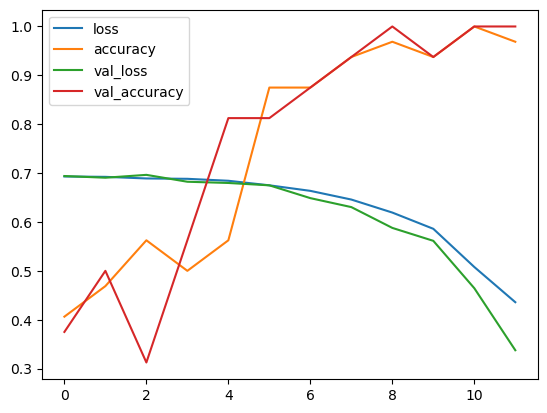

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [ ]:
mod_data.columns[1:]

Index(['Type_Bank Promo', 'Type_Transaction'], dtype='object')

In [ ]:
input_text = vectorizer('A/c *1478 debited Rs. 500.00 on 05-07-24 to Corporation. Not you? SMS BLOCK to 9231000001 Dial 1930 for Cyber Fraud')

In [ ]:
print(np.shape(np.expand_dims(input_text,0)))

(1, 1800)


In [ ]:
output = sequential_model.predict(np.expand_dims(input_text,0))
# Format the output array to remove scientific notation
formatted_output = np.array2string(output, formatter={'float_kind': lambda x: "%.8f" % x})

print(formatted_output)

1/1 [==============================] - 0s 265ms/step
[[0.41020942 0.60653651]]


DistilBERT

In [ ]:
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 20

tkzr = DistilBertTokenizer.from_pretrained(MODEL_NAME)

inputs = tkzr(modData, max_length=MAX_LEN, truncation=True, padding=True)

print(f'input ids: {inputs["input_ids"]}')
print(f'attention mask: {inputs["attention_mask"]}')


In [ ]:
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tkzr(x, max_length=max_len, truncation=trucation, padding=padding)

encodings = construct_encodings(x, tkzr, max_len=MAX_LEN)

In [ ]:
TEST_SPLIT = 0.2
BATCH_SIZE = 2

train_size = int(len(x) * (1-TEST_SPLIT))

tfdataset = tfdataset.shuffle(len(x))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [ ]:
#Model Fine tuning

N_EPOCHS = 2

model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

In [ ]:
benchmarks = model.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)
print(benchmarks)

In [ ]:
def create_predictor(model, model_name, max_len):
  tkzr = DistilBertTokenizer.from_pretrained(model_name)
  def predict_proba(text):
      x = [text]

      encodings = construct_encodings(x, tkzr, max_len=max_len)
      tfdataset = construct_tfdataset(encodings)
      tfdataset = tfdataset.batch(1)

      preds = model.predict(tfdataset).logits
      preds = activations.softmax(tf.convert_to_tensor(preds)).numpy()
      return preds[0][0]

  return predict_proba

clf = create_predictor(model, MODEL_NAME, MAX_LEN)
print(clf('A/c *1478 debited Rs. 500.00 on 05-07-24 to Corporation. Not you? SMS BLOCK to 9231000001 Dial 1930 for Cyber Fraud'))